<a href="https://colab.research.google.com/github/DannyRoss123/AIXHW3/blob/main/HW3AIX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring Black-Box Model Interpretability: Using LIME to Explain ResNet34 Predictions

This Jupyter notebook presents Assignment 3 for our AIX class, focusing on the critical task of interpreting black-box model predictions. I'll be working with ResNet34, a powerful pre-trained model, and using LIME (Local Interpretable Model-agnostic Explanations) to shed light on how it makes individual predictions. By generating local explanations, we can peek inside the 'black box' and understand which parts of our input data most strongly influence the model's decisions. Through LIME and careful visualization, I aim to make ResNet34's decision-making process more transparent and interpretable. This work highlights the growing importance of explainable AI in modern machine learning applications.


### Model Setup and Initial Imports

First let's start with our imports and loading the ResNet34 model. ResNet34 is a pre-trained convolutional neural network that we'll use as our black-box model for this demonstration. The model comes pre-trained on the ImageNet dataset, which means it can recognize a wide variety of objects and animals in images. We'll load it in evaluation mode since we'll only be using it for predictions, not training.



In [1]:
import torch
import torchvision
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

# Download and set up pre-trained ResNet34
model = models.resnet34(pretrained=True)
model.eval()

print("Model loaded successfully!")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 68.2MB/s]


Model loaded successfully!


### Image Preprocessing

The next step is image preprocessing, which is crucial for getting accurate predictions from ResNet34. We need to transform our input images to match exactly what the model expects. This involves resizing the image to a standard size, converting it to a tensor, and normalizing the pixel values using the same statistics that ResNet34 was trained with.

In [2]:

transform = transforms.Compose([
    transforms.Resize(256),          # Resize image to 256x256 pixels
    transforms.CenterCrop(224),      # Crop center to 224x224 pixels
    transforms.ToTensor(),           # Convert to tensor
    transforms.Normalize(            # Normalize with ImageNet mean and std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]    # From Claude AI at 7:40 pm 2/3/2025
    )
])


def preprocess_image(image_path):
    img = Image.open(image_path)

    # Apply transformations
    img_tensor = transform(img)     # Modified from Claude AI at 7:42 pm 2/3/2025

    # Add batch dimension
    img_tensor = img_tensor.unsqueeze(0) #Modified from Claude AI at 7:44 pm 2/3/2025

    return img_tensor, img

print("Preprocessing function ready!")

Preprocessing function ready!


### Image Loading

I downloaded an image of a golden retriever online. This next code snippet handles the image processing pipeline by opening the downloaded image, converting it to the correct format, resizing it to 224x224 pixels, and displaying it. This preprocessing is essential because deep learning models like ResNet34 require images to be in a standardized format.

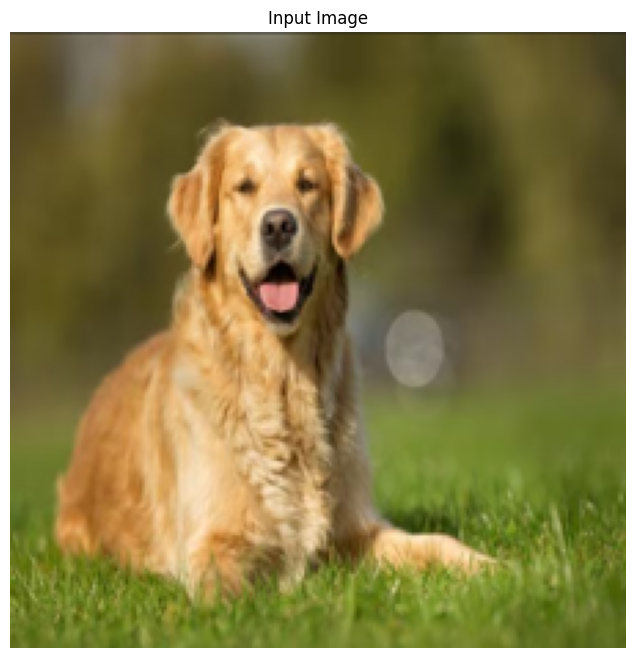

Image processed and saved as 'input_image.jpg'


In [23]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

# Load the uploaded image
image = Image.open('dogimage.png')

# Convert RGBA to RGB if necessary
if image.mode == 'RGBA':
    image = image.convert('RGB')           #Modified from Claude AI 7:47 2/3/2025

# Resize image to ResNet preferred size
image = image.resize((224, 224))

# Save the resized image
image.save('input_image.jpg')

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title("Input Image")
plt.axis('off')
plt.show()

print("Image processed and saved as 'input_image.jpg'")

### Model Prediction and Classification

Our next step is to feed this image into the ResNet34 model and have it predict what the image is. The model will analyze our preprocessed golden retriever image and output both a prediction and a confidence score. ResNet34 was trained on ImageNet's 1000 classes, so it can identify a wide range of objects, animals, and scenes. We'll use the model's class mappings to convert its numerical output into a human-readable label, making it easier to understand what the model thinks it's seeing.


In [25]:
# Import torchvision models class mappings
from torchvision.models import ResNet34_Weights

# Get the class mappings
class_mapping = ResNet34_Weights.IMAGENET1K_V1.meta["categories"]  # modified from Claude AI at 7:58 pm 2/3/2025

def predict_image(sample_img):
    # Process the image
    img_tensor, original_img = preprocess_image('input_image.jpg')

    # Put model in evaluation mode
    model.eval()

    # Get prediction
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
        _, predicted = torch.max(outputs, 1)                             # Modified from Claude AI at 8:00 pm 2/3/2025

    # Get the predicted class name
    predicted_class = class_mapping[predicted.item()]
    confidence = probabilities[predicted.item()]                         # Modified from Claude AI at 8:03 pm 2/3/2025

    print(f"Raw prediction index: {predicted.item()}")
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence score: {confidence.item()*100:.2f}%")

    return predicted.item(), predicted_class

# Test the function
idx, class_name = predict_image('sample_cifar.jpg')

Raw prediction index: 207
Predicted class: golden retriever
Confidence score: 89.99%


### Implementing LIME for Model Interpretability

From the code above, we get that the predicted class is a golden retriever with 89.99% confidence. This is the correct predicted class and shows impressive accuracy from our model. However, just getting the right prediction isn't enough - we want to understand how the model made this decision. This is where LIME comes in. LIME will help us visualize exactly which parts of the image the model is focusing on to make its golden retriever classification. By analyzing these regions, we can verify that the model is using appropriate features for its decision-making process.



In [13]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=0fce58d309cd87b7004869d6cbd63b0b779f41c7da382535942fe67c5532ae7f
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [26]:
import lime
from lime import lime_image
import numpy as np
from skimage.segmentation import mark_boundaries

# Define a function that takes preprocessed images and returns model predictions
def predict_fn(images):
    # Convert images to tensor and normalize them
    batch = torch.stack([transform(Image.fromarray(img.astype('uint8'))) for img in images])  #Modified from Claude AI at 8:08 pm 2/3/2025

    # Get model predictions
    model.eval()
    with torch.no_grad():
        output = model(batch)       #Modified from Claude AI at 8:10 pm 2/3/2025

    # Return the predictions as probabilities
    return output.numpy()

# Create the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Get original image
original_img = Image.open('input_image.jpg')

# Get LIME explanation
explanation = explainer.explain_instance(
    np.array(original_img),
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=100                       #Modified from Claude AI at 8:15 pm 2/3/2025
)

  0%|          | 0/100 [00:00<?, ?it/s]

### Visualizing LIME Explanations

Now that we have implemented LIME, we can create a visualization that reveals which parts of the image were most influential in ResNet34's golden retriever classification. This visualization will present two images side by side: the original golden retriever photo and LIME's explanation mask. The explanation mask will highlight in white the regions that strongly influenced the model's decision, allowing us to verify if the model is focusing on meaningful features like the dog's distinctive fur, face, and body shape, rather than irrelevant background elements.


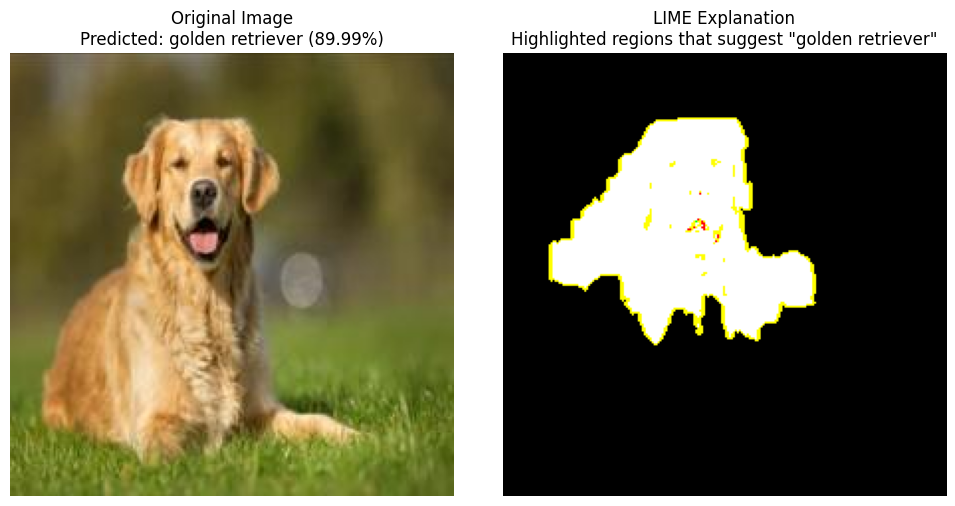

In [28]:
# Get the 'explanation mask'
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],  # Get mask for top prediction
    positive_only=True,         # Show only positive influences
    num_features=5,            # Show top 5 most influential regions
    hide_rest=True
)                            # Modified from Claude AI at 8:23 pm 2/3/2025

# Create the visualization
plt.figure(figsize=(10,5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title('Original Image\nPredicted: golden retriever (89.99%)')
plt.axis('off')

# LIME explanation
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask))
plt.title('LIME Explanation\nHighlighted regions that suggest "golden retriever"')
plt.axis('off')

plt.tight_layout()
plt.show()

### Results Analysis: Understanding ResNet34's Decision Through LIME

From this visualization, we can see that the ResNet34 model not only correctly classified the image as a golden retriever with high confidence (89.99%), but LIME helps us understand exactly why. The LIME explanation on the right reveals that the model is focusing precisely where it should - on the dog's distinctive features rather than the grassy background or other irrelevant elements. The clear white highlight encompasses the entire dog, showing that the model is using the complete set of visual features - from the characteristic golden fur to the breed's distinctive face and body shape - to make its prediction. This is exactly what we want to see in a well-functioning image classifier. This example demonstrates LIME's power as an interpretability tool, showing us that ResNet34 isn't just making correct predictions by chance, but is actually learning and using the right features for classification. By providing this kind of insight into the model's decision-making process, LIME helps build trust in our model's predictions and confirms it's working as intended.

### Discussion of LIME Implementation and Future Improvements

For this assignment, I chose to use LIME to explain ResNet34's predictions because of its intuitive approach to explaining image classifications. LIME works by creating slightly different versions of the input image and seeing how the model's predictions change, which helps identify which parts of the image are most important for the classification. I found this particularly suitable for my implementation with ResNet34 because it provides clear visual feedback about which regions of the image influenced the model's decision.

The strengths of my implementation are clearly demonstrated in the golden retriever example. LIME successfully highlighted the entire dog's body and distinctive features, confirming that ResNet34 is focusing on appropriate regions for its classification. The high confidence score (89.99%) combined with the focused highlighting shows that both the model and the explanation technique are working as intended. This kind of visualization makes it easy for even non-technical users to understand what the model is "looking at" to make its decisions.

However, there are several limitations in my current approach. First, I've only tested this with a single, clear image of a golden retriever. This doesn't give us insight into how well the explanation would work with more challenging images or different classes. Additionally, my implementation uses fairly basic LIME parameters (100 samples, 5 features) which might not be optimal for all cases. The segmentation approach used by LIME can also sometimes be sensitive to the number of samples and image complexity.

Looking forward, there are several ways I could improve this implementation:
1. Test the system with a diverse set of images, including more challenging cases like multiple objects or unusual angles
2. Experiment with different LIME parameters to find optimal settings for different types of images
3. Add comparison with other explanation techniques like SHAP or Anchors to provide multiple perspectives on the model's decisions
4. Implement batch processing to handle multiple images efficiently
5. Add quantitative metrics to evaluate the quality of the explanations

This initial implementation successfully demonstrates how we can peek inside the black box of ResNet34, but there's clearly room for expansion and improvement.

